In [25]:
import os
import glob
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box, mapping
import numpy as np
from PIL import Image
from rasterio.io import MemoryFile
from rasterio.enums import ColorInterp
import matplotlib.pyplot as plt

In [26]:
def generate_mask(image_dir, shapefile_dir, output_mask_dir):
    os.makedirs(output_mask_dir, exist_ok=True)
    tif_files = glob.glob(os.path.join(image_dir, '*.tif'))

    for tif_path in tif_files:
        base_name = os.path.splitext(os.path.basename(tif_path))[0]
        shp_path = os.path.join(shapefile_dir, f"{base_name}.shp")
        output_mask_path = os.path.join(output_mask_dir, f"{base_name}_mask.tif")

        if not os.path.exists(shp_path):
            print(f"Shapefile not found for {base_name}")
            continue

        print(f"Processing {base_name}")

        with rasterio.open(tif_path) as src:
            image_bounds = src.bounds
            image_crs = src.crs
            image_shape = (src.height, src.width)
            transform = src.transform
            profile = src.profile.copy()

        gdf = gpd.read_file(shp_path)
        if gdf.crs != image_crs:
            gdf = gdf.to_crs(image_crs)

        bbox = box(*image_bounds)
        clipped = gdf[gdf.intersects(bbox)].copy()

        if clipped.empty:
            print(f"No buildings in {base_name}")
            continue

        shapes = [(mapping(geom), idx + 1) for idx, geom in enumerate(clipped.geometry)]
        mask = rasterize(
            shapes=shapes,
            out_shape=image_shape,
            transform=transform,
            fill=0,
            dtype='uint8'  # use uint8 for color table compatibility
        )

        # Update profile
        profile.update({
            'driver': 'GTiff',
            'count': 1,
            'dtype': 'uint8',
            'compress': 'lzw',
            'nodata': 0
        })

        # Create color table using matplotlib colormap
        max_label = mask.max()
        cmap = plt.get_cmap("nipy_spectral", max_label + 1)
        color_table = {
            i: tuple(int(255 * c) for c in cmap(i)[:3]) for i in range(1, max_label + 1)
        }
        color_table[0] = (0, 0, 0)  # Background color

        with rasterio.open(output_mask_path, 'w', **profile) as dst:
            dst.write(mask, 1)
            dst.write_colormap(1, color_table)
            dst.colorinterp = [ColorInterp.palette]

        print(f"Saved: {output_mask_path}")

In [27]:
generate_mask('Dataset/train', 'Dataset/train_shp', 'Dataset/train_instances')
generate_mask('Dataset/val', 'Dataset/val_shp', 'Dataset/val_instances')
generate_mask('Dataset/test', 'Dataset/test_shp', 'Dataset/test_instances')

Processing Dataset.0
Saved: Dataset/train_instances\Dataset.0_mask.tif
Processing Dataset.1
Saved: Dataset/train_instances\Dataset.1_mask.tif
Processing Dataset.10
Saved: Dataset/train_instances\Dataset.10_mask.tif
Processing Dataset.11
Saved: Dataset/train_instances\Dataset.11_mask.tif
Processing Dataset.12
Saved: Dataset/train_instances\Dataset.12_mask.tif
Processing Dataset.14
Saved: Dataset/train_instances\Dataset.14_mask.tif
Processing Dataset.17
Saved: Dataset/train_instances\Dataset.17_mask.tif
Processing Dataset.18
Saved: Dataset/train_instances\Dataset.18_mask.tif
Processing Dataset.19
Saved: Dataset/train_instances\Dataset.19_mask.tif
Processing Dataset.21
Saved: Dataset/train_instances\Dataset.21_mask.tif
Processing Dataset.22
Saved: Dataset/train_instances\Dataset.22_mask.tif
Processing Dataset.29
Saved: Dataset/train_instances\Dataset.29_mask.tif
Processing Dataset.30
Saved: Dataset/train_instances\Dataset.30_mask.tif
Processing Dataset.32
Saved: Dataset/train_instances\Da

In [18]:
mask_path = 'Dataset/train_instances/Dataset.1_mask.tif'  # e.g., ''
mask = np.array(Image.open(mask_path))

# Check unique label values
unique_labels = np.unique(mask)
print("Labels in this mask:", unique_labels)

Labels in this mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]


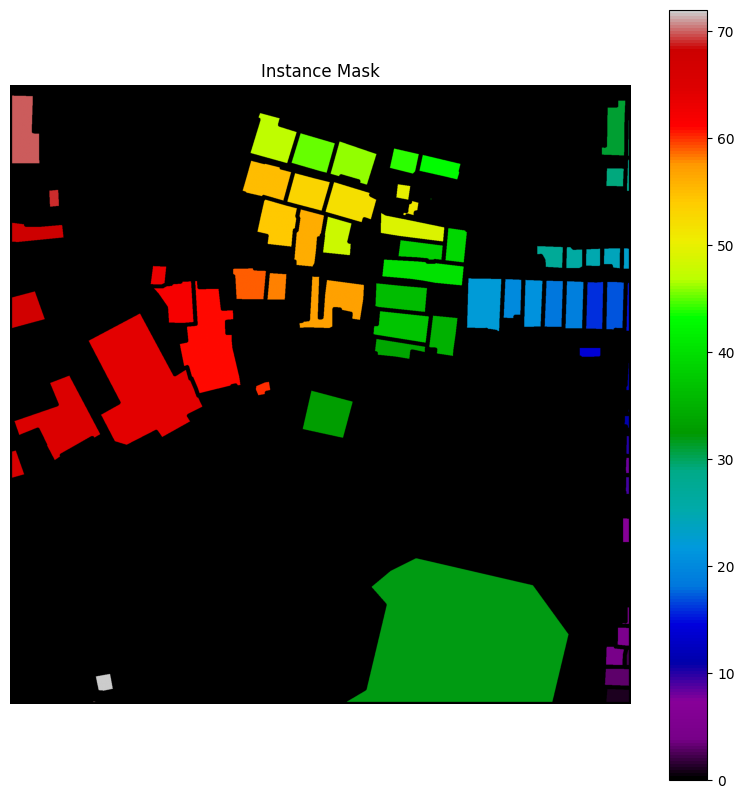

In [19]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("Dataset/train_instances/Dataset.1_mask.tif") as src:
    mask = src.read(1)

plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='nipy_spectral')  # Or 'tab20' or 'viridis'
plt.colorbar()
plt.title("Instance Mask")
plt.axis('off')
plt.show()